# Exploring Twinkles Run1 Data using MySQL tables

---

### Database tables
- I wanted to use `ForcedSource`, `CcdVisit`, and `Object` tables as described at the [LSST schema browser](https://lsst-web.ncsa.illinois.edu/schema/index.php?sVer=baseline), but the Stack [daf_ingest](https://github.com/lsst/daf_ingest) and [datarel](https://github.com/lsst/datarel) packages were basically unusable with `obs_lsstSim` data.
- Instead, I implemented the [pserv package](https://github.com/DarkEnergyScienceCollaboration/pserv) to upload the Stack results to a MySQL db and ingested the Run1.1 data into my KIPAC MySQL tablespace.

```
MySQL [jc_desc]> show tables;
+-------------------+
| Tables_in_jc_desc |
+-------------------+
| CcdVisit          |
| Chisq             |
| ForcedSource      |
| Object            |
| ObjectNumChildren |
+-------------------+
5 rows in set (0.00 sec)

MySQL [jc_desc]> select count(1) from Object;
+----------+
| count(1) |
+----------+
|    41653 |
+----------+
1 row in set (0.08 sec)

MySQL [jc_desc]> select count(1) from ForcedSource;
+----------+
| count(1) |
+----------+
| 33799285 |
+----------+
1 row in set (21.53 sec)

MySQL [jc_desc]> 

```
- The Run1.1 data contain 41653 objects in the merged reference catalog and 33,799,285 sources in the individual forced source catalogs.
- I also wanted to select objects with different levels of variability, so I added a `Chisq` table and filled it with the chi-square values from fitting a constant flux to the `ForcedSource` u-band values.  The [chisq_dists.py](https://github.com/jchiang87/desc_projects/blob/master/twinkles/chisq_dists.py) script that does this is in my [desc_projects](https://github.com/jchiang87/desc_projects) repo.

```
MySQL [jc_desc]> describe Chisq;
+------------+------------+------+-----+---------+-------+
| Field      | Type       | Null | Key | Default | Extra |
+------------+------------+------+-----+---------+-------+
| objectId   | bigint(20) | NO   | PRI | 0       |       |
| filterName | char(1)    | NO   | PRI |         |       |
| chisq      | float      | YES  |     | NULL    |       |
| dof        | int(11)    | YES  |     | NULL    |       |
| chi2prob   | float      | YES  |     | NULL    |       |
+------------+------------+------+-----+---------+-------+
5 rows in set (0.00 sec)

MySQL [jc_desc]> select count(1) from Chisq where filterName='u' and dof=252 and chisq>1e5;
+----------+
| count(1) |
+----------+
|      629 |
+----------+
1 row in set (0.05 sec)

MySQL [jc_desc]> 
```
- In addition, I wanted to select deblended objects.  The `Object` table keeps track of the parent object (i.e., the blend) for any given object, but deblended objects are those entries that are not the parents of any other object, so I created the `ObjectNumChildren` table:

```
MySQL [jc_desc]> describe ObjectNumChildren;
+-------------+------------+------+-----+---------+-------+
| Field       | Type       | Null | Key | Default | Extra |
+-------------+------------+------+-----+---------+-------+
| objectId    | bigint(20) | NO   | PRI | 0       |       |
| numChildren | int(11)    | YES  |     | NULL    |       |
+-------------+------------+------+-----+---------+-------+
2 rows in set (0.02 sec)

MySQL [jc_desc]> 

```
- Finally, I wrote [a couple classes](https://github.com/jchiang87/light_curve_service/blob/master/python/light_curve_service/light_curve_service.py) to generate light curves in the LSST bands.

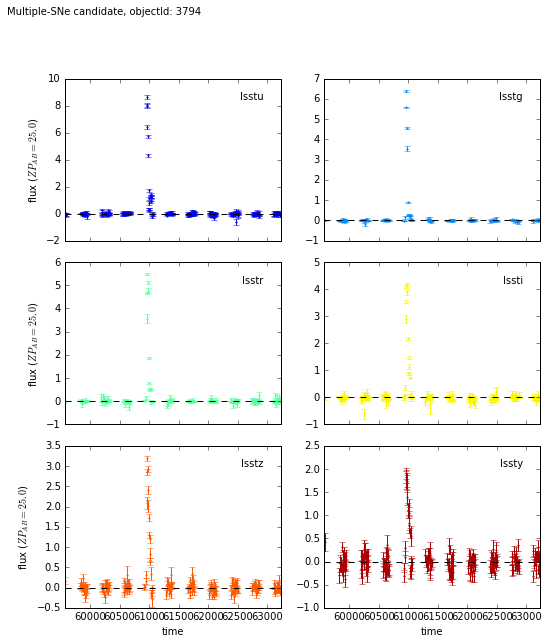

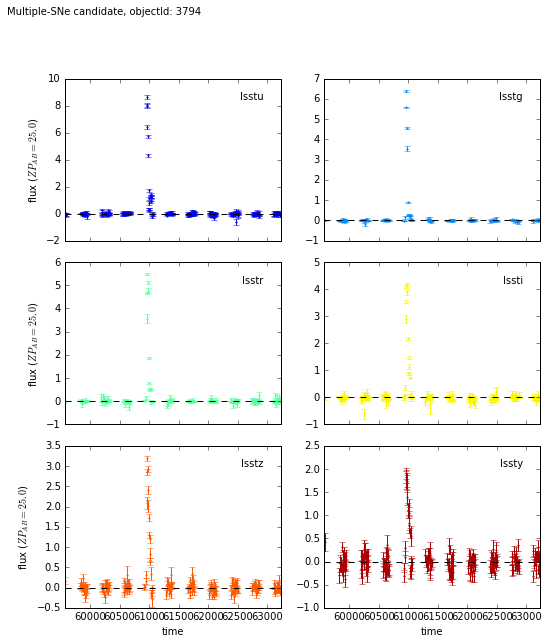

In [1]:
from light_curve_service import LightCurveFactory
%matplotlib inline

lc_factory = LightCurveFactory(db='jc_desc', read_default_file='~/.my.cnf')

# Plot a SNe-like light curve.
objectId = 3794
SN = lc_factory.create(objectId)
SN.plot(figtext='Multiple-SNe candidate, objectId: %i' % objectId)

I don't understand why two sets of plots are generated here.  If I run outside of the notebook, or from a script (see below), only one set is generated.

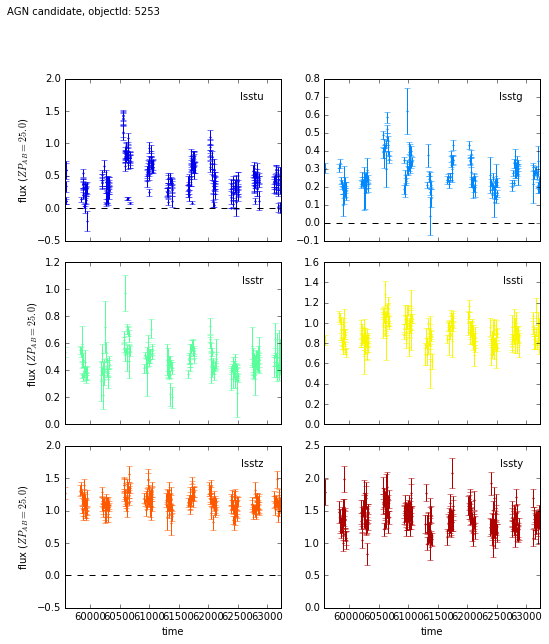

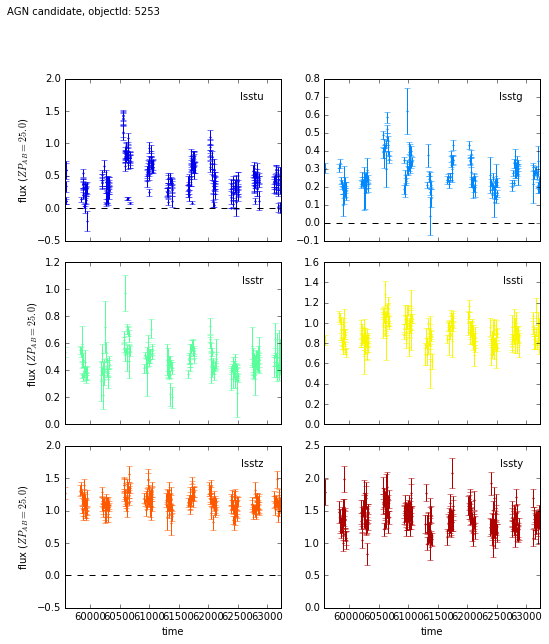

In [2]:
# Plot an AGN-like light curve.
objectId = 5253
AGN = lc_factory.create(objectId)
AGN.plot(figtext='AGN candidate, objectId: %i' % objectId)

---

### Classifying Light Curves
- AGNs and SNe have easily recognizable light curves, but using the flux vs time curves directly, it's not clear which ML algorithm would be effective in distinguishing them.
- Instead, I normalized the fluxes to their peak value and histogrammed them, noting that the multiple-SNe and AGN candidates would would have very different distributions.
- I used K-means to group similar distributions.
- The u band was the best sampled, so I restricted the analysis to those data.

This is implemented in my [kmeans_uband.py](https://github.com/jchiang87/desc_projects/blob/master/twinkles/kmeans_uband.py) script:

select cs.objectId from Chisq cs
           join Object obj on cs.objectId=obj.objectId
           join ObjectNumChildren numCh on obj.objectId=numCh.objectId
           where cs.filterName='u' and cs.dof=249
           and cs.chisq > 1e4
           and numCh.numChildren=0
Found 2795 deblended variable objects for K-means analysis.


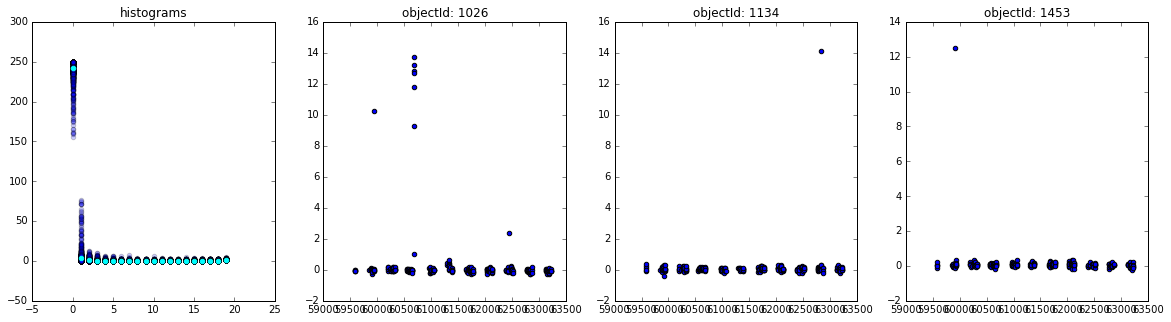

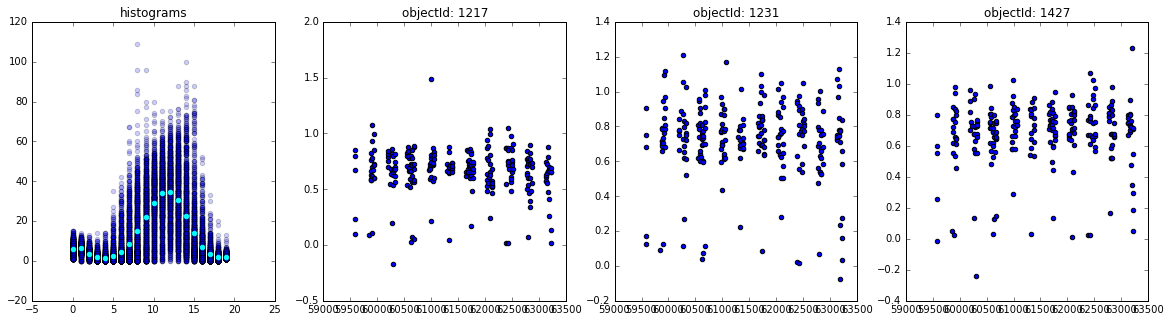

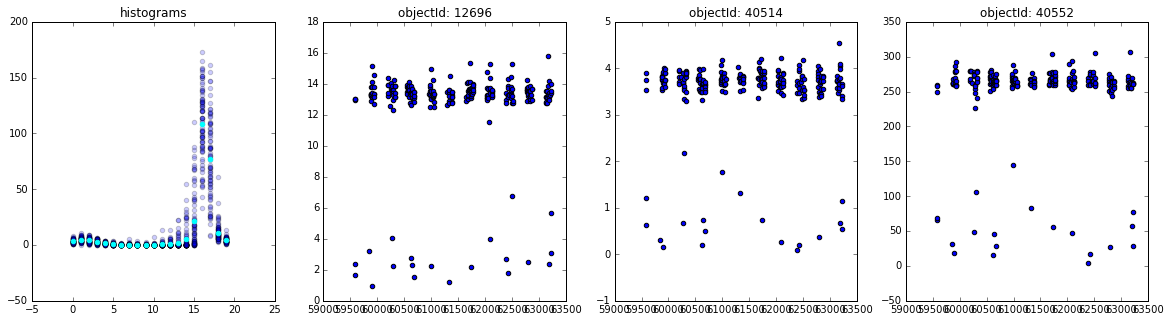

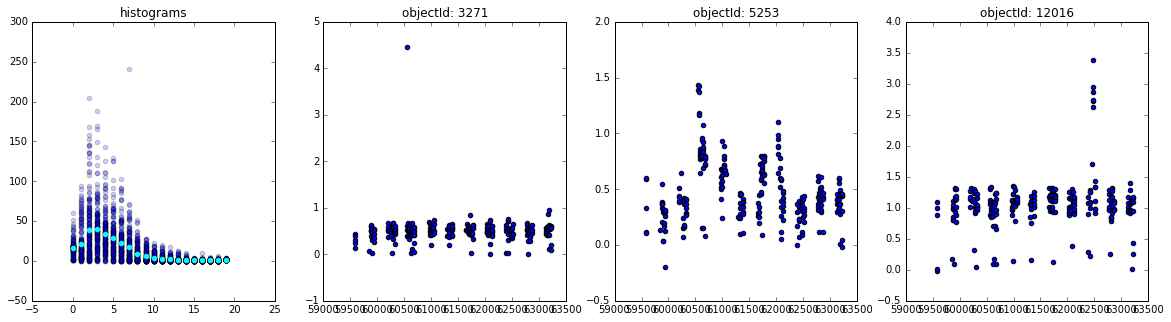

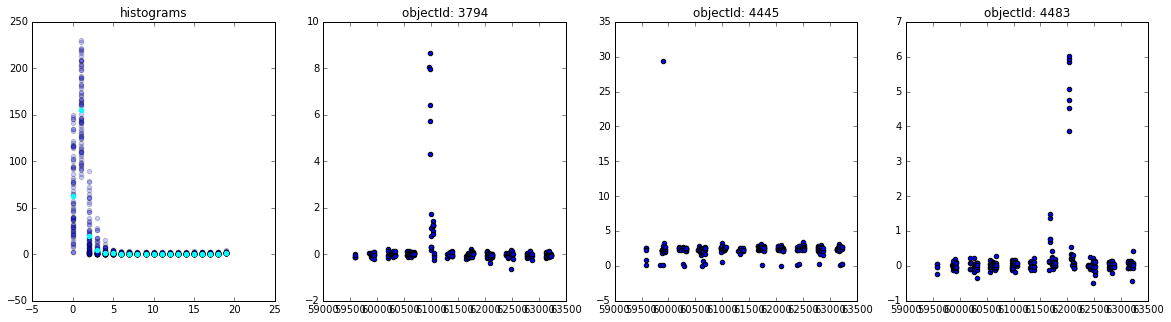

In [3]:
run kmeans_uband

I set the number of clusters to 5 and plotted the histograms in each cluster (and their "center" in cyan) in the first column and plotted the light curves for the first three objects in that cluster.

The sources in the sample are restricted to those with `chisq>1e4` and *without* a `parentObjectId`, i.e., the sample only includes deblended sources as measured by the Stack.  

Note that I added a `numChildren` column to the nominal `Object` table schema to identify the unblended objects.

---

### Postage Stamps and Object Positions

Using the [plot_sources.py](https://github.com/jchiang87/desc_projects/blob/master/twinkles/plot_sources.py) script, we can plot the light curves and 20x20 arcsec postage stamps for each band, overlaying the positions of the objects within those fields:

53.03898382 -27.47396555
select objectId, psRa, psDecl
           from Object obj where
            53.03585294 < psRa and psRa <  53.04211470 and
           -27.47674333 < psDecl and psDecl < -27.47118777
found 26 objects


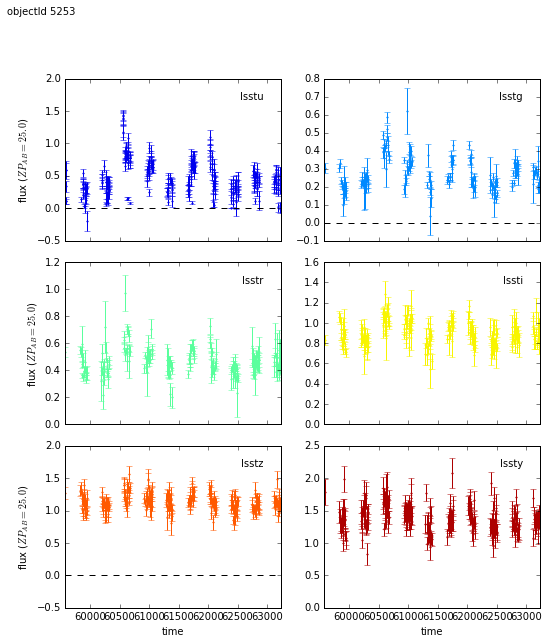

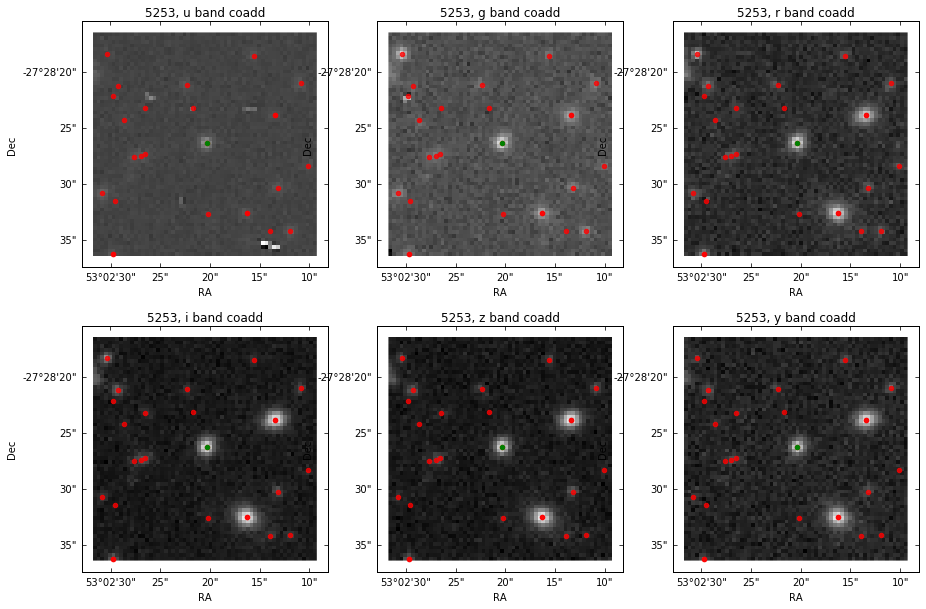

In [4]:
run plot_sources 5253

### Gif Movies
Using my [cineaste.py](https://github.com/jchiang87/desc_projects/blob/master/twinkles/cineaste.py) script, I made [a movie of this field in u-band](https://github.com/jchiang87/desc_projects/blob/master/twinkles/objectId_1628.gif).

---

## To Do
- Fill in more of the [Object table](https://lsst-web.ncsa.illinois.edu/schema/index.php?sVer=baseline&t=Object), especially with the `extendedness` column.
- Fill in more of the [CcdVisit table](https://lsst-web.ncsa.illinois.edu/schema/index.php?sVer=baseline&t=CcdVisit) and find a scheme for generating the `ccdVisitId` value.  Currently, it is being set to be the same as `visitId`, which is ok for now since we have only one sensor.